# Imports

In [1]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import json
import os
# from sodapy import Socrata

# Datetime
import datetime as datetime

import snowflake.connector
# Date
import datetime as dt
import time
from datetime import timedelta

#Math
from math import exp

In [2]:
# # Gets the cursor
# con = snowflake.connector.connect(
#     user='meagan',
#     password='',
#     account='hu40871.us-east-1',
#     warehouse='ANALYSIS'
#     )
# cur = con.cursor()

# # insert query here
# cur.execute('''
#     SELECT  * 
#     FROM    "WAREHOUSE"."GOLD"."SUBSCRIPTION_RETENTION"
#            ''')

## Acuity

In [3]:
silver = pd.read_csv('Acuity.csv')
silver.head()

,EVENT_TS,EVENT_TS_UTC,ANONYMOUS_ID,EVENT,APPOINTMENT_BODY_CALENDAR,APPOINTMENT_BODY_FIRST_NAME,APPOINTMENT_BODY_DATETIME_CREATED,APPOINTMENT_BODY_CALENDAR_ID,APPOINTMENT_BODY_CALENDAR_TIMEZONE,EMAIL,APPOINTMENT_BODY_DATE,APPOINTMENT_BODY_DURATION,APPOINTMENT_BODY_TIMEZONE,APPOINTMENT_DATE_TIME,APPOINTMENT_BODY_LAST_NAME,APPOINTMENT_BODY_TYPE,APPOINTMENT_BODY_ID,APPOINTMENT_TYPE_ID,APPOINTMENT_BODY_CANCELED,APPOINTMENT_BODY_NO_SHOW
0,2020-10-25 08:37:35.955,2020-10-25 15:37:35.955,464303198,appointment_scheduled,"Dr. Anya Arthen, ND",Ginger,2020-10-25 10:37:32.000,3513713.0,America/New_York,ginger.deshotels@icloud.com,"November 4, 2020",20.0,America/Chicago,2020-11-04 12:50:00.000,Deshotels,Hair Consultation,464303198.0,12799707.0,False,NaN
1,2020-10-06 16:33:10.415,2020-10-06 23:33:10.415,454504090,appointment_scheduled,"Dr. Ariana Zastrow, ND",Vivian,2020-10-06 18:33:07.000,3684820.0,America/New_York,vburgess53@icloud.com,"October 8, 2020",15.0,America/New_York,2020-10-08 17:30:00.000,Burgess,Follow Up Consultation,454504090.0,16040988.0,False,NaN
2,2020-12-12 06:29:43.878,2020-12-12 14:29:43.878,489836193,appointment_scheduled,"Dr. Katelyn Cloyd, ND",Giovanni,2020-12-12 08:29:41.000,3508236.0,America/New_York,ruciglione@gmail.com,"January 7, 2021",20.0,America/New_York,2021-01-07 17:05:00.000,Turi,Hair Consultation,489836193.0,12799707.0,False,NaN
3,2020-12-05 17:46:52.374,2020-12-06 01:46:52.374,486300624,appointment_scheduled,"Dr. Katelyn Cloyd, ND",Nancy,2020-12-05 19:46:49.000,3508236.0,America/New_York,njoymann50@aol.com,"December 22, 2020",20.0,America/New_York,2020-12-22 13:00:00.000,Mann,Hair Consultation,486300624.0,12799707.0,False,NaN
4,2021-01-06 01:34:32.789,2021-01-06 09:34:32.789,502063803,appointment_scheduled,"Dr. Anya Arthen, ND",kendra,2021-01-06 03:34:29.000,3513713.0,America/New_York,kendralinde@gmail.com,"January 22, 2021",20.0,America/New_York,2021-01-22 13:15:00.000,Linde,Hair Consultation,502063803.0,12047150.0,False,NaN


In [4]:
# Create a copy of the DB
silver_acuity = silver.copy()
silver_acuity.shape

(19861, 20)

In [5]:
# Change dates to datetime Dtype
silver_acuity['APPOINTMENT_BODY_DATE'] = pd.to_datetime(silver_acuity['APPOINTMENT_BODY_DATE'])
# silver_acuity.columns

# Drop unneeded columns
silver_acuity.drop(columns=['EVENT_TS', 'EVENT_TS_UTC', 'ANONYMOUS_ID','APPOINTMENT_BODY_FIRST_NAME',
       'APPOINTMENT_BODY_DATETIME_CREATED', 'APPOINTMENT_BODY_CALENDAR_ID','APPOINTMENT_BODY_CALENDAR_TIMEZONE',\
                    'APPOINTMENT_BODY_TIMEZONE', 'APPOINTMENT_BODY_LAST_NAME', 'APPOINTMENT_BODY_ID',\
                    'APPOINTMENT_BODY_NO_SHOW', \
                    'APPOINTMENT_TYPE_ID'], inplace=True)

silver_acuity.isnull().sum()
# Check for null values
# sns.heatmap(silver_acuity.isnull(), cbar=False)

EVENT                          0
APPOINTMENT_BODY_CALENDAR    278
EMAIL                        353
APPOINTMENT_BODY_DATE        278
APPOINTMENT_BODY_DURATION    278
APPOINTMENT_DATE_TIME        278
APPOINTMENT_BODY_TYPE        278
APPOINTMENT_BODY_CANCELED    278
dtype: int64

In [6]:
# drop irrelevant appointments
na_dict= {'appointment_canceled' : np.nan,
'appointment_changed' : np.nan,
'appointment_rescheduled' : np.nan}

silver_acuity['EVENT'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['EVENT'].value_counts()

appointment_scheduled    4006
Name: EVENT, dtype: int64

In [7]:
# drop irrelevant appointments
na_dict= {'Hair Mineral Analysis Appointment':np.nan,
          'Follow Up Consultation':np.nan,
          'Customer consultation':np.nan,
          'Case Study':np.nan}

silver_acuity['APPOINTMENT_BODY_TYPE'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      3400
Hair Mineral Analysis - Acquisition       3
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [8]:
#Round to the day
silver_acuity['APPOINTMENT_BODY_DATE'] = silver_acuity['APPOINTMENT_BODY_DATE'].dt.round('D')

silver_acuity['Today'] = pd.Timestamp('today')
silver_acuity['Today'] = silver_acuity['Today'].dt.round('D')

silver_acuity['Complete'] = (silver_acuity['Today']>silver_acuity['APPOINTMENT_BODY_DATE'])
silver_acuity['Complete'].value_counts()

True     3072
False     331
Name: Complete, dtype: int64

In [9]:
# Remove appointments in the future
silver_acuity['Complete'] = silver_acuity['Complete'].astype('str')

# drop irrelevant appointments
na_dict= {'False' : np.nan}

silver_acuity['Complete'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['Complete'].value_counts()

True    3072
Name: Complete, dtype: int64

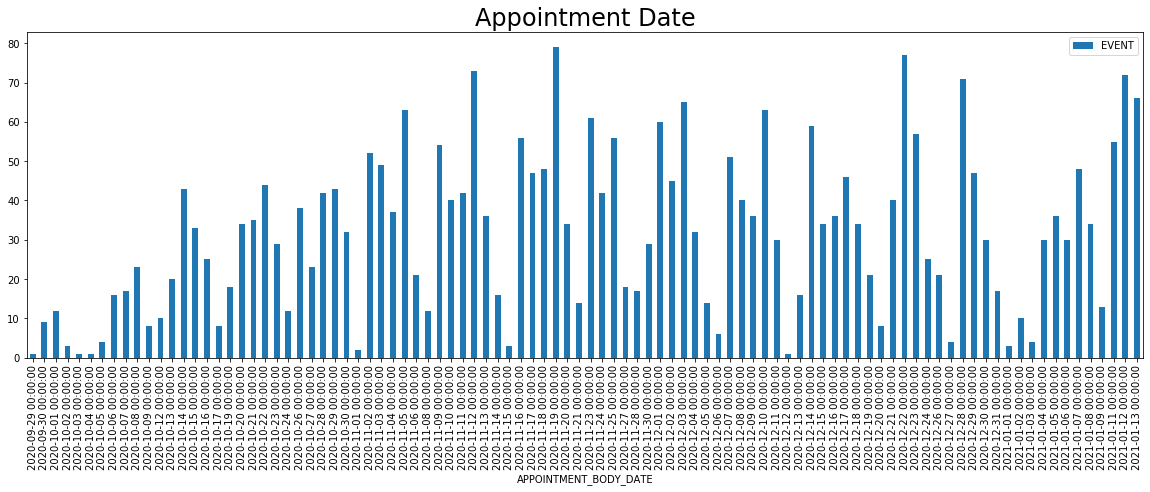

In [10]:
# Group by event, for a visual only 
chart = silver_acuity.groupby(["APPOINTMENT_BODY_DATE"]).agg({'EVENT':'count'})
chart.isna().sum()

chart.plot(kind='bar',figsize=(20,6))
plt.title("Appointment Date", size= 24)
plt.show()

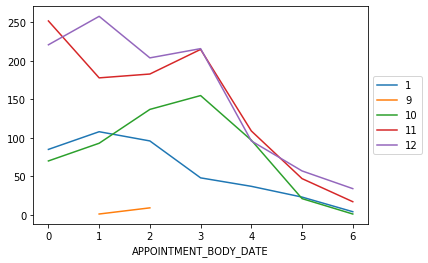

In [11]:
(silver_acuity.groupby([silver_acuity['APPOINTMENT_BODY_DATE'].dt.dayofweek,\
                       silver_acuity['APPOINTMENT_BODY_DATE'].dt.month])\
 ['EVENT'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [12]:
min(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2020-09-29 00:00:00')

In [13]:
max(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2021-01-13 00:00:00')

In [14]:
# Looking at specific email addresses
# silver_acuity.loc[silver_acuity['EMAIL']=='XXXX@yahoo.com']

# AGG
clean_acuity = silver_acuity.loc[silver_acuity.groupby('EMAIL')['APPOINTMENT_BODY_DATE'].idxmin()]
clean_acuity.shape

(2739, 10)

In [15]:
clean_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      2738
Hair Mineral Analysis - Acquisition       1
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [16]:
# yyy = gold.shape
# print ('shape = ',yyy)

smail = clean_acuity['EMAIL'].nunique()
print ('unique emails = ',smail)

unique emails =  2739


## SUB

In [17]:
gold_sub = pd.read_csv('GOLD.csv')
# gold_sub.head()

In [18]:
# Create a copy of the dataframe
gold = gold_sub.copy()
gold.columns

Index(['SUBSCRIPTION_ID', 'CUSTOMER_ID', 'EMAIL', 'STATUS', 'ITEM_NAME',
       'ITEM_GROUP', 'ITEM_SUB_TYPE', 'ITEM_GENDER', 'TOTAL_ITEMS',
       'FIRST_ORDER_AT', 'GROSS_ORDER_VALUE', 'TOTAL_ORDERS',
       'TOTAL_ORDER_VALUE'],
      dtype='object')

In [19]:
# Change dates to datetime 
gold['FIRST_ORDER_AT'] = pd.to_datetime(gold['FIRST_ORDER_AT'])
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161570 entries, 0 to 161569
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   SUBSCRIPTION_ID    161570 non-null  int64         
 1   CUSTOMER_ID        161570 non-null  int64         
 2   EMAIL              161570 non-null  object        
 3   STATUS             113040 non-null  object        
 4   ITEM_NAME          161543 non-null  object        
 5   ITEM_GROUP         161543 non-null  object        
 6   ITEM_SUB_TYPE      161543 non-null  object        
 7   ITEM_GENDER        161543 non-null  object        
 8   TOTAL_ITEMS        161543 non-null  float64       
 9   FIRST_ORDER_AT     161570 non-null  datetime64[ns]
 10  GROSS_ORDER_VALUE  161543 non-null  float64       
 11  TOTAL_ORDERS       161517 non-null  float64       
 12  TOTAL_ORDER_VALUE  161517 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), 

In [20]:
# min(gold['FIRST_ORDER_AT'])
# max(gold['FIRST_ORDER_AT'])

yyy = gold.shape
gemail = gold['EMAIL'].nunique()
print ('shape = ',yyy)
print ('unique emails = ',gemail)

shape =  (161570, 13)
unique emails =  42765


In [21]:
gold['ITEM_GENDER'].value_counts()

Women                                      130814
Men                                         26133
Men,Women                                    1653
Women,Men                                    1635
Women,Women                                  1065
Men,Men                                        62
Women,Women,Women,Women                        44
Women,Men,Women                                35
Men,Women,Men,Women,Women,Women,Men,Men        28
Men,Women,Women                                26
Women,Women,Men                                24
Women,Men,Women,Women                          20
Women,All                                       4
Name: ITEM_GENDER, dtype: int64

In [22]:
# clean up work location for 4 main boroughs
gold.loc[gold['ITEM_GENDER'] =='Men,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Men,Women,Men,Women,Women,Women,Men,Men', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Men,Women,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Women,Men', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Men', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,All', 'ITEM_GENDER']= 'Women'
gold.loc[gold['ITEM_GENDER'] =='Women,Women,Women,Women', 'ITEM_GENDER']= 'Women'
gold.loc[gold['ITEM_GENDER'] =='Women,Women', 'ITEM_GENDER']= 'Women'
gold.loc[gold['ITEM_GENDER'] =='Men,Men', 'ITEM_GENDER']= 'Men'


In [23]:
# clean up data
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
gold.loc[gold['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'

gold['ITEM_SUB_TYPE'].value_counts()

GrowthPlan                                                                                            90675
GrowthPlan 3                                                                                          41532
GrowthPlan 2                                                                                          24735
Combination                                                                                            3847
GrowthPlan 2,GrowthPlan 2                                                                               146
GrowthPlan 2,GrowthPlan                                                                                 136
GrowthPlan 3,GrowthPlan 2                                                                               106
GrowthPlan 2,GrowthPlan 3                                                                                74
GrowthPlan,GrowthPlan,GrowthPlan                                                                         57
GrowthPlan 3,Non-Sub        

In [24]:
# AGG
df = gold.iloc[gold.groupby('EMAIL')['GROSS_ORDER_VALUE'].idxmin()]
df.shape

(42765, 13)

In [25]:
df.loc[df['FIRST_ORDER_AT']>'2020-09-29 00:00:00'].count()

SUBSCRIPTION_ID      29451
CUSTOMER_ID          29451
EMAIL                29451
STATUS               29451
ITEM_NAME            29451
ITEM_GROUP           29451
ITEM_SUB_TYPE        29451
ITEM_GENDER          29451
TOTAL_ITEMS          29451
FIRST_ORDER_AT       29451
GROSS_ORDER_VALUE    29451
TOTAL_ORDERS         29448
TOTAL_ORDER_VALUE    29448
dtype: int64

In [26]:
df.head()

,SUBSCRIPTION_ID,CUSTOMER_ID,EMAIL,STATUS,ITEM_NAME,ITEM_GROUP,ITEM_SUB_TYPE,ITEM_GENDER,TOTAL_ITEMS,FIRST_ORDER_AT,GROSS_ORDER_VALUE,TOTAL_ORDERS,TOTAL_ORDER_VALUE
102415,507892,446224,0127351@gmail.com,active,Nutrafol for Women + Liver Support,G-Plan,GrowthPlan 2,Women,1.0,2020-09-16 07:03:24,89.0,4.0,257.0
123083,609589,545230,01hookerville@gmail.com,active,Nutrafol for Women's Balance + Hairbiotic + B-...,G-Plan,GrowthPlan 3,Women,1.0,2020-12-17 10:28:50,99.0,1.0,79.2
95428,553939,488077,03moni91@gmail.com,active,Nutrafol for Women + Hairbiotic + Stress Adapt...,G-Plan,GrowthPlan 3,Women,1.0,2020-10-26 12:44:38,99.0,3.0,297.0
129516,626944,561745,0512mommy@gmail.com,active,Nutrafol for Women,Core,GrowthPlan,Women,1.0,2020-12-31 09:27:55,79.0,1.0,79.0
39704,638335,572728,06attisha@gmail.com,active,Nutrafol for Men,Core,GrowthPlan,Men,1.0,2021-01-06 23:27:53,79.0,1.0,79.0


In [27]:
gross = df['GROSS_ORDER_VALUE'].mean()
orderValue = df['TOTAL_ORDER_VALUE'].mean()
Items  = df['TOTAL_ITEMS'].mean()
orders = df['TOTAL_ORDERS'].mean()

print(gross, orderValue, Items, orders)

91.69468373670057 211.9993005308691 1.0718344440547176 2.5377095951918807


In [28]:
min(df['FIRST_ORDER_AT'])

Timestamp('2020-08-01 00:09:46')

## Merge

In [29]:
sub1 = pd.merge(clean_acuity,df,how='left',on='EMAIL')

In [30]:
gold.columns

Index(['SUBSCRIPTION_ID', 'CUSTOMER_ID', 'EMAIL', 'STATUS', 'ITEM_NAME',
       'ITEM_GROUP', 'ITEM_SUB_TYPE', 'ITEM_GENDER', 'TOTAL_ITEMS',
       'FIRST_ORDER_AT', 'GROSS_ORDER_VALUE', 'TOTAL_ORDERS',
       'TOTAL_ORDER_VALUE'],
      dtype='object')

In [31]:
# Create a copy of the dataframe
sub = sub1.copy()

sub = sub[[ 'EMAIL','APPOINTMENT_BODY_DATE', 'FIRST_ORDER_AT',\
           'ITEM_GROUP', 'ITEM_SUB_TYPE','TOTAL_ITEMS','TOTAL_ORDERS',
           'ITEM_NAME', 'ITEM_GENDER', 'GROSS_ORDER_VALUE','TOTAL_ORDER_VALUE']]
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2739 entries, 0 to 2738
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   EMAIL                  2739 non-null   object        
 1   APPOINTMENT_BODY_DATE  2739 non-null   datetime64[ns]
 2   FIRST_ORDER_AT         1415 non-null   datetime64[ns]
 3   ITEM_GROUP             1415 non-null   object        
 4   ITEM_SUB_TYPE          1415 non-null   object        
 5   TOTAL_ITEMS            1415 non-null   float64       
 6   TOTAL_ORDERS           1415 non-null   float64       
 7   ITEM_NAME              1415 non-null   object        
 8   ITEM_GENDER            1415 non-null   object        
 9   GROSS_ORDER_VALUE      1415 non-null   float64       
 10  TOTAL_ORDER_VALUE      1415 non-null   float64       
dtypes: datetime64[ns](2), float64(4), object(5)
memory usage: 256.8+ KB


In [32]:
max(sub['FIRST_ORDER_AT'])

# # create start year column to be able to make years_working column
# df['start_year'] = df['Agency Start Date'].apply(lambda x: int(x[6:]))
# df['years_with_city'] = df[['Fiscal Year']].sub(df['start_year'], axis=0)

Timestamp('2021-01-12 11:58:22')

In [33]:
sub['TimeDifference'] = \
(((sub['APPOINTMENT_BODY_DATE']))-(sub['FIRST_ORDER_AT']))
sub.head()

,EMAIL,APPOINTMENT_BODY_DATE,FIRST_ORDER_AT,ITEM_GROUP,ITEM_SUB_TYPE,TOTAL_ITEMS,TOTAL_ORDERS,ITEM_NAME,ITEM_GENDER,GROSS_ORDER_VALUE,TOTAL_ORDER_VALUE,TimeDifference
0,101akpatel@gmail.com,2020-12-18,2020-12-05 20:47:46,G-Plan,GrowthPlan 3,1.0,2.0,Nutrafol for Women + Hairbiotic + Stress Adapt...,Women,99.0,198.00,12 days 03:12:14
1,11consesa@gmail.com,2020-11-17,2020-09-13 19:59:39,G-Plan,GrowthPlan 3,1.0,1.0,Nutrafol for Women's Balance + Hairbiotic + St...,Women,99.0,74.25,64 days 04:00:21
2,22reverie@gmail.com,2020-11-05,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,2reachmari@gmail.com,2021-01-12,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,33mhb@comcast.net,2020-12-28,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [34]:
sub['ITEM_GROUP'].value_counts()

G-Plan           846
Core             559
Core,G-Plan        7
G-Plan,G-Plan      1
Core,Core          1
G-Plan,Core        1
Name: ITEM_GROUP, dtype: int64

In [35]:
sub['ITEM_SUB_TYPE'].value_counts()

GrowthPlan      559
GrowthPlan 3    522
GrowthPlan 2    324
Combination      10
Name: ITEM_SUB_TYPE, dtype: int64

In [36]:
submail = sub['EMAIL'].nunique()
print ('unique emails = ',submail)

unique emails =  2739


In [37]:
gross = df['GROSS_ORDER_VALUE'].mean()
cgross = sub['GROSS_ORDER_VALUE'].mean()
OV = df['TOTAL_ORDER_VALUE'].mean()
COV = sub['TOTAL_ORDER_VALUE'].mean()
Items  = df['TOTAL_ITEMS'].mean()
orders = df['TOTAL_ORDERS'].mean()

print('Total Gross Order Value = ',gross)
print('Consult Gross Order Value = ',cgross)

print('Total Gross Order Value = ',OV)
print('Consult Gross Order Value = ',COV)

Total Gross Order Value =  91.69468373670057
Consult Gross Order Value =  94.2374558303887
Total Gross Order Value =  211.9993005308691
Consult Gross Order Value =  227.6218021201425


In [38]:
# Export data
sub.to_csv('sub.csv')

In [39]:
sub.shape

(2739, 12)